___
<img style="float: right; margin: 0px 0px 15px 15px;" src="https://www.researchgate.net/publication/331474581/figure/fig1/AS:1131188974567432@1646707876257/A-unified-deep-learning-framework-for-time-series-classification.png" width="500px" height="300px" />


# <font color= #8A0829> Clasificación de series de tiempo usando LSTMs.</font>

<Strong> Objetivos </Strong>
- Cómo desarrollar y evaluar un conjunto de modelos de redes neuronales LSTM para el reconocimiento de la actividad humana a partir de datos de acelerómetros.
- Cómo desarrollar un modelo unidimensional de Red Neuronal Convolucional LSTM, o CNN-LSTM.
- Cómo desarrollar un modelo LSTM Convolucional unidimensional, o ConvLSTM, para el mismo problema.

> Referencias:
    > - https://towardsdatascience.com/time-series-classification-with-deep-learning-d238f0147d6f
    > - Capítulo 25 de [Deep Learning for Time Series Forecasting: Predict the Future with MLPs, CNNs and LSTMs in Python](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/)
___

# 1. Modelo LSTM 
Los modelos de redes LSTM son un tipo de redes neuronales recurrentes capaces de aprender y recordar secuencias largas de datos de entrada. Están pensadas para su uso con datos compuestos por secuencias largas de datos, de hasta **200 o 400 pasos temporales**. Pueden ser adecuadas para este problema. El modelo puede soportar múltiples secuencias paralelas de datos de entrada, como cada eje de los datos del acelerómetro y el giroscopio.  La ventaja de utilizar LSTM para la clasificación de secuencias es que pueden aprender directamente de los datos de series temporales sin procesar y, a su vez, no requieren conocimientos especializados para diseñar manualmente las características de entrada.

## 1.1 Cargar Human Activity Recognition (HAR) data

En la clases anteriores realizamos una exploración, análisis y modelado de los datos de HAR. Ahora vamos a proceder a modelar dichos datos para poder realizar una clasificación de series de tiempo usando LSTM y CNN que nos permita predecir la actividad humana usando señales de sensores de celulr. Para ello, vamos a utilizar el mismo set de datos estudiados la clase anterior. Recordar que cada serie de datos se ha dividido en ventanas superpuestas de 2,65 segundos de datos, o 128 pasos temporales.

In [30]:
# Importar librerías
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.layers import TimeDistributed
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dropout 
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.layers import LSTM
import matplotlib.pyplot as plt
from keras.layers import Dense
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
# Crear función que lee los datos de un archivo en formato txt y los retorna en un dataframe. Están separados por espacios en blanco
def load_file(filename):
    df = pd.read_csv(filename, delim_whitespace=True, header=None)
    return df.values

# Crear función que lee los datos de entrenamiento y de prueba
def load_group(filenames, prefix=''):
    loaded = [load_file(prefix + f) for f in filenames]

    # Apilar los datos en un solo array de 3 dimensiones
    loaded = np.dstack(loaded)
    return loaded

# Crear función que lee los datos de entrenamiento y de prueba
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # cargar los 9 archivos como un único array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_' + group + '.txt', 'total_acc_y_' + group + '.txt',
                  'total_acc_z_' + group + '.txt']
    # body acceleration
    filenames += ['body_acc_x_' + group + '.txt', 'body_acc_y_' + group + '.txt',
                  'body_acc_z_' + group + '.txt']
    # body gyroscope
    filenames += ['body_gyro_x_' + group + '.txt', 'body_gyro_y_' + group + '.txt',
                  'body_gyro_z_' + group + '.txt']
    # cargar input data
    X = load_group(filenames, filepath)
    # cargar class output
    y = load_file(prefix + group + '/y_' + group + '.txt')
    return X, y

In [5]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # Cargo los datos de entrenamiento
    trainX, trainy = load_dataset_group('train', prefix)
    print('datos de entrenamiento', trainX.shape, trainy.shape, sep='\n')
    # Cargo los datos de prueba
    testX, testy = load_dataset_group('test', prefix)
    print('datos de prueba',testX.shape, testy.shape, sep='\n')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print('datos luegos del one-hot encode', trainX.shape, trainy.shape, testX.shape, testy.shape, sep='\n')
    return trainX, trainy, testX, testy

In [37]:
# Cargar los datos de entrenamiento y de prueba
trainX, trainy, testX, testy = load_dataset('UCI HAR Dataset/')

datos de entrenamiento
(7352, 128, 9)
(7352, 1)
datos de prueba
(2947, 128, 9)
(2947, 1)
datos luegos del one-hot encode
(7352, 128, 9)
(7352, 6)
(2947, 128, 9)
(2947, 6)


## 1.2 Ajustar y evaluar el modelo

Vamos a definir una función que se encargar de tomar los datos de entrenamiento y prueba, ajuste el modelo con los datos de prueba y evalue el rendimiento con los datos de prueba y retorne dicho valor. Recuerde que el modelo requiere que los datos sean tridiminsionales con `[samples, timesteps, features]`.

In [7]:
# Definir características del modelo
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

In [10]:
# Ajustar y evaluar el modelo
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 15, 64
    
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

Luego de tener nuestra función de evaluación del modelo procederemos a crear tres funciones adicionales. La `repeat_evaluate_model` que se encargará de llamar la función `evaluate_model` n veces. Luego tendremos otra función llamada `summarize_results` donde se obtendrán las estadísticas en las métricas de error que se obtuvieron en cada repetición del modelo. Finalmente, se creará una función `run_experiment` la cual orquestará el llamado de las dos funciones anteriores.

In [11]:
# Repetir la evaluación del modelo
def repeat_evaluate_model(trainX, trainy, testX, testy, n_repeats=10):
    scores = list()
    for i in range(n_repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>%d: %.3f' % (i+1, score))
        scores.append(score)
    return scores

In [12]:
# Resumen de los resultados
def summarize_results(n_repeats):
    # Ejecutar la evaluación del modelo
    scores = repeat_evaluate_model(trainX, trainy, testX, testy, n_repeats)
    # Imprimir el resumen
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [15]:
# Ejecutar el experimento
def run_experiment(n_repeats=10):
    # Cargar los datos
    trainX, trainy, testX, testy = load_dataset('UCI HAR Dataset/')

    # Resumir los resultados
    summarize_results(n_repeats)

In [17]:
# Ejecutar el primer experimento
run_experiment()

datos de entrenamiento
(7352, 128, 9)
(7352, 1)
datos de prueba
(2947, 128, 9)
(2947, 1)
datos luegos del one-hot encode
(7352, 128, 9)
(7352, 6)
(2947, 128, 9)
(2947, 6)
>1: 90.261
>2: 90.397
>3: 91.177
>4: 89.345
>5: 90.465
>6: 90.533
>7: 89.583
>8: 90.193
>9: 88.191
>10: 90.126
[90.26128053665161, 90.39701223373413, 91.17746949195862, 89.34509754180908, 90.46487808227539, 90.53274393081665, 89.58262801170349, 90.19341468811035, 88.19137811660767, 90.12554883956909]
Accuracy: 90.027% (+/-0.777)


# 2. Modelo CNN-LSTM 

Como vimos en sesiones anteriores, la combinación de redes convolucionales y recurrentes es de especial importancia ya que las redes convoluciones permiten extraer de forma muy eficiente las características de la serie de tiempo y las redes recurrentes interpreta la dependencia temporal de dichas características extraídas. Para la implementación de este modelo debemos particionar cada ventana de 128 pasos de tiempo en subsecuencias para el modelo CNN. Para nuestro caso particionaremos nuestros 128 pasos de tiempo en 4 subsecuencias de 32 pasos cada una.

Con esto vamos a proponer una modelo CNN que espere leer secuencias de longitud 32 y 9 características. El modelo completo de CNN puede ser envuelto por una capa `TimeDistributed`, la cuál permite aplicar una capa a cada segmento temporal de una entrada, es decir aplicar la misma capa Conv1D a cada uno de los 4 intervalos de tiempo, de forma independiente. 

Es común usar dos capas CNN consecutivas seguidas por capas de dropout y maxpooling. Con estas indicaciones podemos actualizar nuestra función `evaluate_model`.

In [26]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    # Definir el modelo
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[-1], trainy.shape[1]
    
    # reshape data a time steps of sub-sequences
    n_steps, n_length = 4, 32
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    
    # Definir el modelo
    model = Sequential()
    model.add(TimeDistributed(Conv1D(64, 3, activation='relu'), input_shape=(None, n_length, n_features)))
    model.add(TimeDistributed(Conv1D(64, 3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D()))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Ajustar el modelo
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

In [25]:
trainX.shape[-1]

9

In [29]:
# Ejecutar el segundo experimento
run_experiment(5)

datos de entrenamiento
(7352, 128, 9)
(7352, 1)
datos de prueba
(2947, 128, 9)
(2947, 1)
datos luegos del one-hot encode
(7352, 128, 9)
(7352, 6)
(2947, 128, 9)
(2947, 6)
>1: 90.838
>2: 91.245
>3: 91.144
>4: 87.038
>5: 88.870
[90.83814024925232, 91.24533534049988, 91.14353656768799, 87.03766465187073, 88.87003660202026]
Accuracy: 89.827% (+/-1.641)


# 3. Modelo ConvLSTM 

Otra ampliación de la idea CNN-LSTM consiste en realizar las convoluciones de la CNN (por ejemplo cómo la CNN lee los datos de la secuencia de entrada) como parte de la LSTM. Esta combinación se denomina LSTM convolucional o ConvLSTM y tiene una estructura como se muestra a continuación.

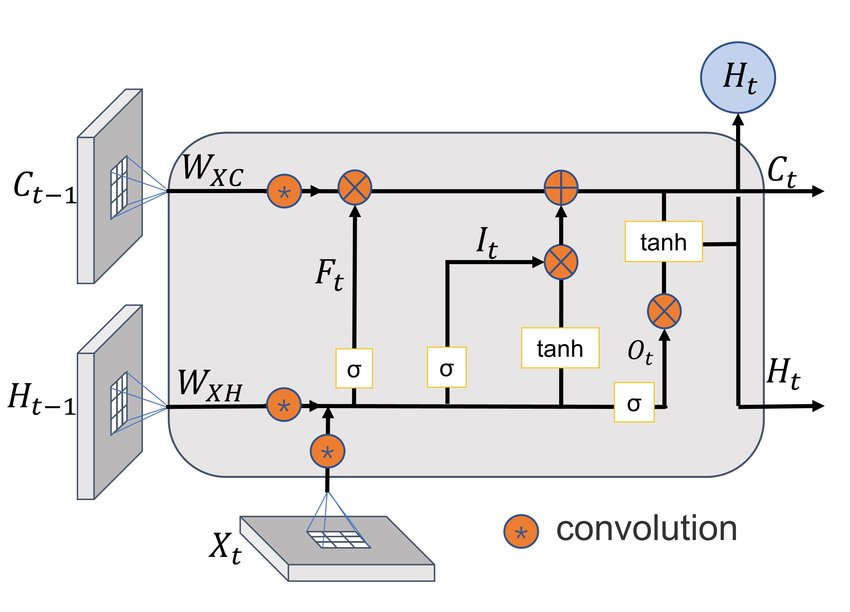

Esta capa espera por defecto tener un tamaño de entrada `[samples, time, rows, cols, channels]`, donde cada time step es definido como una imagen de (rows x columns) datos. Para el caso que estamos trabajando el número de rows es 1 ya que se tienen los datos unidimensionales y el número de columnas representa el número de time steps en la subsecuencia, que según definimos anteriormente es 32. De esta manera los datos para nuestra capa `ConvLSTM2D` serían:
- Muestras: n, para el número de ventanas del conjunto de datos.
- Tiempo: 4, para las cuatro subsecuencias en que dividimos una ventana de 128 pasos temporales.
- Filas: 1, para la forma unidimensional de cada subsecuencia.
- Columnas: 32, para los 32 pasos temporales de una subsecuencia de entrada.
- Canales: 9, para las nueve variables de entrada.

Recordar que el `ConvLSTM2D` requiere tanto la configuración para el modelo CNN como LSTM (cantidad de filtros, tamaño del kernel y función de activación). Con esta información ya podemos preparar los datos para el `ConvLSTM2D`.

In [32]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    # Definir el modelo
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[-1], trainy.shape[1]
    
    # reshape data a time steps of sub-sequences
    n_steps, n_length = 4, 32
    trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
    
    # Definir el modelo
    model = Sequential()
    model.add(ConvLSTM2D(64, (1,3), 
                         activation='relu', 
                         input_shape=(n_steps, 1, n_length,n_features)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Ajustar el modelo
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

In [33]:
# Ejecutar el tercer experimento
run_experiment(5)

datos de entrenamiento
(7352, 128, 9)
(7352, 1)
datos de prueba
(2947, 128, 9)
(2947, 1)
datos luegos del one-hot encode
(7352, 128, 9)
(7352, 6)
(2947, 128, 9)
(2947, 6)
>1: 91.279
>2: 90.974
>3: 89.718
>4: 91.856
>5: 91.653
[91.27926826477051, 90.97387194633484, 89.71835970878601, 91.85612201690674, 91.65253043174744]
Accuracy: 91.096% (+/-0.753)


# Ajuste de hiperparámetros

In [36]:
trainX.shape, trainy.shape

((7352, 4, 32, 9), (7352, 6))

In [41]:
from keras.callbacks import EarlyStopping
import pandas as pd
import tensorflow as tf
import optuna

def objective(trial):
    global trainX, trainy, testX
    
    # Definir los hiperparámetros a ajustar
    batch_size = trial.suggest_int('filters', 32, 128)
    filters = trial.suggest_int('filters', 32, 128)
    kernel_size = trial.suggest_int('kernel_size', 3, 11)
    
    num_neurons = trial.suggest_int('num_neurons', 16, 256)
    dropout_rate = trial.suggest_float('rate', 0.0, 0.7)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1)
    epochs = trial.suggest_int('epochs', 10, 200)
    verbose = 0
    
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[-1], trainy.shape[1]
    
    # reshape data a time steps of sub-sequences
    n_steps, n_length = 4, 32
    trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
    
    # Definir el modelo
    model = Sequential()
    model.add(ConvLSTM2D(filters, (1, kernel_size), 
                         activation='relu', 
                         input_shape=(n_steps, 1, n_length,n_features)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    
    # Compilar el modelo con los hiperparámetros ajustados
    model.compile(loss='categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  metrics=['accuracy']
                 )
    
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=15)

    # Ajustar el modelo
    model.fit(trainX, 
              trainy, 
              epochs=epochs, 
              validation_split=.1,
              shuffle=False,
              batch_size=batch_size, 
              verbose=verbose,
              callbacks=[earlystop]
             )
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    return accuracy

# Definir el objeto de estudio de Optuna y ejecutar la búsqueda de hiperparámetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Imprimir los resultados
print('Best trial:', study.best_trial.params)
print('Best validation loss:', study.best_trial.value)


[I 2023-04-11 13:10:15,823] A new study created in memory with name: no-name-22440ea8-bc7e-491e-b02e-c5a48a4c8433
[W 2023-04-11 13:10:56,619] Trial 0 failed with parameters: {'filters': 58, 'kernel_size': 5, 'num_neurons': 80, 'rate': 0.017375073017910556, 'learning_rate': 0.09304745848812958, 'epochs': 116} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/f_/yfk7pckx1pvcrgw8dsns53yr0000gn/T/ipykernel_28300/1818772886.py", line 46, in objective
    model.fit(trainX,
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/Users/user/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
    tmp_logs = self.train_function(iterator)
  File "/Users/us

KeyboardInterrupt: 

# Extensiones

Además de los modelos LSTM y CNN vistos en esta sesión, hay variaciones que pueden explorarse que pueden mejorar nuestro modelo.
- **Stacked LSTM**: Una posibilidad de mejora es en lugar de considerar sólo una capa LSTM considerar varias (consecutivamente) y validar si los resultados mejoran.
- **Bidirecntional LSTM**: Otra posibilidad es utilizar las redes bidireccionales para que en lugar de sólo aprender de comportamientos hacia atrás de la serie de tiempo, también aprenda patrones hacia adelante de la serie de tiempo.
- **Multi head CNN**: Como vimos en sesiones previas, otra posibilidad que puede explorarse para mejorar los resultados de nuestro modelo es considere una capa CNN por cada una de las 9 features de nuestra serie de tiempo y validar si dicha variación mejora nuestros resultados.
- **GRU**: Otra buena elección como posible variación está en considerar la red recurrente GRU y contrastar con los resultados arrojados por las redes LSTM.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Oscar David Jaramillo Zuluaga.
</footer>